In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import json
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import matplotlib.patches as patches
from IPython.display import Markdown

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
parent_dir = os.path.abspath(os.path.join(os.path.dirname("./"), '..'))
sys.path.append(parent_dir)
from tools.lineup_tpr import LineupTPR
from tools.pickler import Save_Model, Load_Model
from tools.draw_pitch_plot import Draw_Pitch_Actions
from tools.fm_attributes import Attributes
fm_attributes = Attributes.attribute_list
gk_attributes = Attributes.gk_attributes

In [4]:
players_df = pd.read_csv("../players_db/fm23/fm23db_processed.csv")
team_df = pd.read_csv("../players_db/fm23/team_ratings.csv")

<br><br><br><br><br><br><br><br>
<h2 style="color:SteelBlue;background:Lime;"> Preparing Train Data w/Player Logs</h2>

In [5]:
from IPython.display import display, HTML
loading_bar_html = """
<div id="progress-container" style="width: 50%; border: 1px solid #ccc; margin: 20px 0;">
  <div id="progress-bar" style="width: 0%; height: 20px; background-color: #4CAF50; text-align: center; line-height: 20px; color: white;"></div>
</div>
<script>
function updateProgressBar(progress) {
  var progressBar = document.getElementById('progress-bar');
  progressBar.style.width = progress + '%';
  progressBar.innerHTML = progress + '%';
}
</script>
"""

In [6]:
page_names = ['shooting', 'passing', 'defense', 'keeper', 'passing_types', 'gca', 'possession', 'misc']

In [7]:
# display(HTML(loading_bar_html))
# process = 0

# for p_name in page_names:
#     url = f"https://fbref.com/en/comps/Big5/2022-2023/{p_name}/players/2022-2023-Big-5-European-Leagues-Stats"
#     scraped_data = pd.read_html(url)[0]
#     try:
#         scraped_data.columns = scraped_data.columns.get_level_values(1)
#     except:
#         pass
#     progress = int((process + 1) / len(page_names) * 100)
#     process+=1
#     display(HTML("<script>updateProgressBar({})</script>".format(progress)))
#     scraped_data.to_csv(f"../player_logs/Big5@22-23@{p_name}@players.csv",index=False)

<br>
<h3 style="color:yellow;background:SteelBlue;">  Passing</h3>

In [8]:
title = "shooting"
pdf_csv_src = f"../player_logs/Big5@22-23@{title}@players"

# shot_Volume
pdf = pd.read_csv(f"{pdf_csv_src}.csv").dropna(axis=0)
pdf["Att_Shot"] = pd.to_numeric(pdf["Sh"], errors='coerce')
pdf["Shot/90"] = pd.to_numeric(pdf["Att_Shot"], errors='coerce') / pd.to_numeric(pdf["90s"], errors='coerce')

# shot_Accuracy
pdf["Shot_Accuracy"] = pd.to_numeric(pdf["SoT%"], errors='coerce')

export_pdf_csv_src = f"../player_logs/trainable/Big5@22-23@{title}@players"
pdf.to_csv(f"{export_pdf_csv_src}@Trainable.csv", index=False)

<br>
<h3  style="color:yellow;background:SteelBlue;">  Shooting</h3>

In [9]:
title = "passing"
pdf_csv_src = f"../player_logs/Big5@22-23@{title}@players"

# pass_Volume
pdf = pd.read_csv(f"{pdf_csv_src}.csv").dropna(axis=0)
pdf["Att_Pass"] = pd.to_numeric(pdf["Att.1"], errors='coerce')
pdf["Pass/90"] = pd.to_numeric(pdf["Att_Pass"], errors='coerce') / pd.to_numeric(pdf["90s"], errors='coerce')

# pass_Accuracy
pdf["Pass_Accuracy"] = pd.to_numeric(pdf["Cmp%.1"], errors='coerce')

export_pdf_csv_src = f"../player_logs/trainable/Big5@22-23@{title}@players"
pdf.to_csv(f"{export_pdf_csv_src}@Trainable.csv", index=False)

<br>
<h3  style="color:yellow;background:SteelBlue;">  Possession</h3>

In [10]:
title = "possession"
pdf_csv_src = f"../player_logs/Big5@22-23@{title}@players"

# pass_Volume
pdf = pd.read_csv(f"{pdf_csv_src}.csv").dropna(axis=0)
pdf["Att_Dribble"] = pd.to_numeric(pdf["Att"], errors='coerce')
pdf["Dribble/90"] = pd.to_numeric(pdf["Att_Dribble"], errors='coerce') / pd.to_numeric(pdf["90s"], errors='coerce')

# pass_Accuracy
pdf["Dribble_Accuracy"] = pd.to_numeric(pdf["Succ%"], errors='coerce')

export_pdf_csv_src = f"../player_logs/trainable/Big5@22-23@{title}@players"
pdf.to_csv(f"{export_pdf_csv_src}@Trainable.csv", index=False)

In [11]:
title = "possession"
pdf_csv_src = f"../player_logs/trainable/Big5@22-23@{title}@players@Trainable.csv"
pd.read_csv(pdf_csv_src)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Touches,...,1/3,CPA,Mis,Dis,Rec,PrgR,Matches,Att_Dribble,Dribble/90,Dribble_Accuracy
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21,2000,26.4,1143,...,34,13,71,82,767,151,Matches,100.0,3.787879,34.0
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18,2003,1.9,99,...,2,2,5,2,65,15,Matches,6.0,3.157895,50.0
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18,2004,0.7,39,...,0,0,1,1,21,0,Matches,1.0,1.428571,100.0
3,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34,1987,37.0,2459,...,21,3,27,23,1499,10,Matches,37.0,1.000000,56.8
4,6,Himad Abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,22,1999,23.7,1516,...,60,7,36,20,1066,111,Matches,76.0,3.206751,56.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,2885,Szymon Żurkowski,pl POL,MF,Fiorentina,it Serie A,24,1997,0.4,25,...,1,1,1,1,18,4,Matches,1.0,2.500000,0.0
2575,2886,Szymon Żurkowski,pl POL,MF,Spezia,it Serie A,24,1997,4.7,169,...,4,2,14,3,87,10,Matches,11.0,2.340426,72.7
2576,2887,Martin Ødegaard,no NOR,MF,Arsenal,eng Premier League,23,1998,34.7,2100,...,60,26,42,45,1550,193,Matches,83.0,2.391931,57.8
2577,2888,Milan Đurić,ba BIH,FW,Hellas Verona,it Serie A,32,1990,15.2,644,...,5,3,26,15,551,72,Matches,6.0,0.394737,33.3


<br>
<h3  style="color:yellow;background:red;">  ddd</h3>

<br><br><br><br><br><br><br><br>
<h2 style="color:lightgreen;background:blue;">Action Player Volume & Accuracy Regression</h2>

In [12]:
def Prepare_Action_Player_Volume_Accuracy_Regression_Data(players_df, csv_file, filter_column, filter_value, target_variable, target_volume=None, top_playersN=None, top_colsN=None, fm_attributes=None, gk_excluded=None):
    fb2_raw = pd.read_csv(csv_file)
    fb2_raw[filter_column] = pd.to_numeric(fb2_raw[filter_column], errors="coerce")
    fb2_raw[target_variable] = pd.to_numeric(fb2_raw[target_variable], errors="coerce")
    fb2_raw[target_volume] = pd.to_numeric(fb2_raw[target_volume], errors="coerce")
    fb2 = fb2_raw[fb2_raw[filter_column] > filter_value]
    
    if target_volume:
        fb_actions = fb2.sort_values(by=target_variable, ascending=False)[["Pos","Squad","Player",target_volume,target_variable]]
    else:
        fb_actions = fb2.sort_values(by=target_variable, ascending=False)[["Pos","Squad","Player",target_volume,target_variable]]
        
    fb_actions["Pos"] = fb_actions["Pos"].apply(lambda row: row.split(",")[0])
    merged_df_raw = pd.merge(players_df, fb_actions, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))
    
    if gk_excluded:
        merged_df = merged_df_raw[merged_df_raw["Best_Pos"] != "GK"]
    else:
        merged_df = merged_df_raw
        
    top_players = merged_df.sort_values(by=target_variable, ascending=False).head(top_playersN)
    position_mean = top_players["Pos_Rank_Average"].mean()
    top_attributes = top_players[fm_attributes].mean().sort_values(ascending=False).head(top_colsN).index
    
    return {
        "zero": 0,
        "target": target_variable,
        "raw_df": fb2_raw,
        "df": merged_df,
        "position_mean": position_mean,
        "top_playersN": top_playersN,
        "reg_cols": np.concatenate((top_attributes, ["Pos_Rank_Average"], ["tpr","tpr_club"])),
    }

In [13]:
def Train_Model(df, reg_cols, target, test_size):
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression 
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    X = df[reg_cols]
    y = df[target].astype(float)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_raw = model.predict(X_test)
    y_pred = [max(0, pred) for pred in y_pred_raw]
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "model": model,
        "mse": mse,
        "mae": mae,
        "r2": r2
    }

In [14]:
def DictToPredictionDict(d: dict) -> pd.DataFrame:
    rdict = {}
    for k,v in d.items():
        rdict[k] = [v]
    return pd.DataFrame(rdict)

def PlayerPredict(model, current_df, current_target, reg_cols, player_name, print_stats=False):
    d0 = current_df.query(f"Name == '{player_name}'").iloc[0]
    d1 = d0[reg_cols].to_dict()
    d2 = DictToPredictionDict(d1)
    
    print(f"Name:\t\t{d0['Name']}")
    print(f"Pos_Rank_Avg:\t{d0['Pos_Rank_Average']}")
    if print_stats:
        print(f"Real:\t\t{d0[current_target]}")
    prediction = max(0, model.predict(d2)[0])
    print(f"Prediction:\t[{prediction}]")
    return prediction

def Model_Predict(model, row, cols):
    d1 = row[cols].to_dict()
    d2 = DictToPredictionDict(d1)
    prediction = max(0, model.predict(d2)[0])
    return float(round(prediction, 2))

<br><br>

<br><br><br><br><br><br><br><br>
<h2 style="color:black;background:LightSkyBlue;">  Tuning </h2>

In [15]:
tf = pd.read_csv("../player_logs/Big5@22-23@passing@players.csv")

In [16]:
tf.iloc[0].to_dict()

{'Rk': '1',
 'Player': 'Brenden Aaronson',
 'Nation': 'us USA',
 'Pos': 'MF,FW',
 'Squad': 'Leeds United',
 'Comp': 'eng Premier League',
 'Age': '21',
 'Born': '2000',
 '90s': '26.4',
 'Cmp': '592',
 'Att': '797',
 'Cmp%': '74.3',
 'TotDist': '7577',
 'PrgDist': '2182',
 'Cmp.1': '346',
 'Att.1': '423',
 'Cmp%.1': '81.8',
 'Cmp.2': '150',
 'Att.2': '195',
 'Cmp%.2': '76.9',
 'Cmp.3': '25',
 'Att.3': '65',
 'Cmp%.3': '38.5',
 'Ast': '3',
 'xAG': '4.2',
 'xA': '2.6',
 'A-xAG': '-1.2',
 'KP': '46',
 '1/3': '47',
 'PPA': '16',
 'CrsPA': '4',
 'PrgP': '86',
 'Matches': 'Matches'}

In [17]:
loop = {
    "filter_min":900,
    "filter_max":1800,
    "filter_step":100,
    "target_variable":"Att.1",
    "target_volume":"Att",
    "csv_file":"../player_logs/Big5@22-23@passing@players.csv",
    # "csv_file":"data/Big5@Players@Passing@2022_2023.csv",
    "filter_column":"Att",
    "gk_excluded":False
}

with open("data/models_hyperparam.txt", "w", encoding="utf-8") as f:
    f.truncate(0)
    
mae = 100
target_variable = loop["target_variable"]
target_volume = loop["target_volume"]
csv_file = loop["csv_file"]
filter_column = loop["filter_column"]
gk_excluded = loop["gk_excluded"]
range_df = pd.read_csv(csv_file)
filter_min = loop["filter_min"]
filter_max = loop["filter_max"]
filter_step = loop["filter_step"]

for filter_value in range(filter_min, filter_max, filter_step):
    for top_playersN in range(20, 100, 10):
        for top_colsN in range(10, len(fm_attributes), 3):
            prep_by = Prepare_Action_Player_Volume_Accuracy_Regression_Data(
                players_df,
                csv_file=csv_file,
                filter_column=filter_column,
                filter_value=filter_value,
                target_variable=target_variable,
                target_volume=target_volume,
                top_playersN=top_playersN,
                top_colsN=top_colsN,
                fm_attributes=fm_attributes,
                gk_excluded=gk_excluded
            )
            
            chosen_dict = {
                "df": prep_by["df"],
                "reg_cols": prep_by["reg_cols"],
                "target": prep_by["target"],
            }
            
            current_df = pd.merge(team_df, chosen_dict["df"], how="inner", left_on="fbref_name", right_on="Squad", suffixes=("_club",""))
            for num in range(10,10+1):
                test_size = round(num/100, 2)
                this_mae = Train_Model(current_df, chosen_dict["reg_cols"], chosen_dict["target"], test_size)["mae"]
                if this_mae < mae:
                    mae = this_mae
                    best_result = (target_variable, filter_value, top_playersN, top_colsN, test_size, mae)
                    markdown_str = f"""
                    | Target | Filter Value | Top Players N | Top Columns N | Test Size | Mean Absolute Error (MAE) |
                    |--------|--------------|---------------|---------------|-----------|----------------------------|
                    | {best_result[0]} | {best_result[1]} | {best_result[2]} | {best_result[3]} | {best_result[4]} | {best_result[5]} |
                    """
                    with open("data/models_hyperparam.txt", "a", encoding="utf-8") as f:
                        f.write(markdown_str)
                        f.write("\n\n")

<br><br><br><br><br><br><br><br>
<h2 style="color:aqua;background:yellow;">  Creating Models</h2>

In [18]:
pd.read_excel("data/player_action_hyper.xlsx")

,Title,csv_file,gk_excluded,filter_column,filter_value,top_playersN,top_colsN,test_size,MAE,target_variable,target_volume
0,pass_Volume,Big5@Players@Passing@2022_2023.csv,False,90s,21,60,46,0.20,6553.000,Pass/90,Att
1,shot_Volume,Big5@Players@Shooting@2022_2023.csv,True,90s,21,30,10,0.11,0.262,Sh/90,Sh
2,dribble_Volume,Big5@Players@Dribbling@2022_2023.csv,True,90s,15,70,10,0.13,0.562,Dribble/90,Att
3,pass_Accuracy,Big5@Players@Passing@2022_2023.csv,False,Att,1700,20,43,0.11,2700.000,Pass_Accuracy,Att
4,shot_Accuracy,Big5@Players@Shooting@2022_2023.csv,True,Sh,39,80,19,0.10,4712.000,Shot_Accuracy,Sh
5,dribble_Accuracy,Big5@Players@Dribbling@2022_2023.csv,True,Take-Ons,57,20,37,0.15,4888.000,Dribble_Accuracy,Take-Ons


In [19]:
def Create_Action_Model(action_title, team_df):
    # action_title = "Shooting_Volume"
    hyper_df = pd.read_excel("data/player_action_hyper.xlsx")
    title_df = hyper_df[hyper_df["Title"]==action_title].iloc[0]
    
    prep_by = Prepare_Action_Player_Volume_Accuracy_Regression_Data(
        players_df,
        csv_file="data/"+title_df["csv_file"],
        filter_column=title_df["filter_column"],
        filter_value=title_df["filter_value"],
        target_variable=title_df["target_variable"],
        target_volume=title_df["target_volume"],
        top_playersN=title_df["top_playersN"],
        top_colsN=title_df["top_colsN"],
        fm_attributes=fm_attributes,
        gk_excluded=title_df["gk_excluded"]
    )
    
    chosen_dict = {
        "df": prep_by["df"],
        "raw_df": prep_by["raw_df"],
        "reg_cols": prep_by["reg_cols"],
        "target": prep_by["target"],
        "test_size": title_df["test_size"],
    }
    
    current_df = pd.merge(team_df, chosen_dict["df"], how="inner", left_on="fbref_name", right_on="Squad", suffixes=("_club",""))
    model = Train_Model(current_df, chosen_dict["reg_cols"], chosen_dict["target"], chosen_dict["test_size"])["model"]
    return {
        "hyperparam_info_file": hyper_df,
        "prep_data": prep_by,
        "model": model,
        "chosen_dict": chosen_dict,
        "train_cols": chosen_dict["reg_cols"]
    }

In [20]:
# hyper_df = pd.read_excel("data/player_action_hyper.xlsx")
# players_df = pd.read_csv("../players_db/fm23/fm23db_processed.csv")
# team_df = pd.read_csv("../players_db/fm23/team_ratings.csv")

# all_df = pd.merge(team_df, players_df, how="inner", left_on="Club", right_on="Club", suffixes=("_club",""))
# for title in hyper_df["Title"]:
#     model = Create_Action_Model(title, team_df)["model"]
#     # Save_Model("_", f"./models/{title}_model", model)
#     # all_df[title] = all_df.apply(lambda row: Model_Predict(model, row, model.feature_names_in_), axis=1)
#     # predicted_df = all_df[[title,"tpr_club","UID"]]

# output_cols = np.concatenate((players_df.columns, hyper_df["Title"].tolist(), ["tpr_club"]))
# all_df.loc[all_df['Best_Pos'] == 'GK', 'shot_Volume'] = 0
# all_df.loc[all_df['Best_Pos'] == 'GK', 'dribble_Volume'] = 0
# # all_df[output_cols].to_csv("../players_db/fm23/fm23db_processed_with_futsim_triple_models.csv", index=False)

# predicted_cols = hyper_df["Title"].tolist()
# test_team = LineupTPR(all_df, "Manchester City")[["Club","Name","Playing_Position","Pos_Rank_Average"] + predicted_cols] \
# .sort_values("Pos_Rank_Average", ascending=False)
# test_team["Shot_Weight_Prob"] = test_team["shot_Volume"] / test_team["shot_Volume"].sum()

<br><br><br><br><br><br><br><br>
<h2 style="color:aqua;background:purple;">  Predictoria</h2>

In [21]:
predicted_df = pd.read_csv("../players_db/fm23/fm23db_processed_with_futsim_triple_models.csv")
location_df = pd.read_csv("data/location_df.csv")
volume_formula_df = pd.read_csv("formulas/Attacking_Touches_volume_formula_df_hyper.csv", index_col=0) # Attacking_Touches
touches_triple_prob_df = pd.read_csv("data/touches_triple_prob.csv")
touches_triple_prob_df["Triple_Prob_Dict"] = touches_triple_prob_df.Triple_Prob_Dict.apply(ast.literal_eval)

In [22]:
pass_positional_location_df = pd.read_csv("../statsbomb/data/position_included_location_384_squared_ligue1_Pass.csv").query("position!='ALL'")
shot_positional_location_df = pd.read_csv("../statsbomb/data/position_included_location_384_squared_ligue1_Shot.csv").query("position!='ALL'")
dribble_positional_location_df = pd.read_csv("../statsbomb/data/position_included_location_384_squared_ligue1_Dribble.csv").query("position!='ALL'")
positional_location_df = {
    "Pass":pass_positional_location_df,
    "Shot":shot_positional_location_df,
    "Dribble":dribble_positional_location_df,
}

In [23]:
touches_df_raw_1 = pd.read_csv("../match_logs/Big5@22-23@attacking_touches.csv")
touches_df_raw_2 = pd.merge(touches_df_raw_1, team_df, left_on="Club", right_on="Club", how="inner") 
touches_df = pd.merge(touches_df_raw_2, team_df, left_on="Opponent", right_on="fbref_name", how="inner").dropna()

<br><br><br><br>
### f()

In [24]:
fm_managerial_tactics = {
    'Standard': {"Pass": 1.0, "Shot": 1.0, "Dribble": 1.0},
    'Gegen - Direct': {"Pass": 1.2, "Shot": 1.0, "Dribble": 0.8},
    'Gegen - High Tempo': {"Pass": 1.1, "Shot": 1.1, "Dribble": 0.9},
    'Gegen - Slow Passing': {"Pass": 0.9, "Shot": 1.0, "Dribble": 1.0},
    'Gegen - Wing Play': {"Pass": 1.3, "Shot": 1.0, "Dribble": 0.7},
    
    'Tiki Taka - Direct': {"Pass": 1.5, "Shot": 0.8, "Dribble": 0.8},
    'Tiki Taka - High Tempo': {"Pass": 1.4, "Shot": 0.9, "Dribble": 0.8},
    'Tiki Taka - Slow Passing': {"Pass": 1.6, "Shot": 0.7, "Dribble": 0.9},
    'Tiki Taka - Wing Play': {"Pass": 1.7, "Shot": 0.6, "Dribble": 0.8},
    
    'Control - Direct': {"Pass": 1.1, "Shot": 1.0, "Dribble": 1.0},
    'Control - High Tempo': {"Pass": 1.0, "Shot": 1.1, "Dribble": 1.0},
    'Control - Slow Passing': {"Pass": 1.0, "Shot": 0.9, "Dribble": 1.1},
    'Control - Wing Play': {"Pass": 1.2, "Shot": 1.0, "Dribble": 0.9},
    
    'Counter - Direct': {"Pass": 0.8, "Shot": 1.2, "Dribble": 1.0},
    'Counter - High Tempo': {"Pass": 0.9, "Shot": 1.1, "Dribble": 1.1},
    'Counter - Slow Passing': {"Pass": 0.7, "Shot": 1.0, "Dribble": 1.2},
    'Counter - Wing Play': {"Pass": 0.8, "Shot": 1.3, "Dribble": 1.0},
    
    'Total Football - Direct': {"Pass": 1.2, "Shot": 1.2, "Dribble": 1.0},
    'Total Football - High Tempo': {"Pass": 1.1, "Shot": 1.3, "Dribble": 1.0},
    'Total Football - Slow Passing': {"Pass": 1.3, "Shot": 1.1, "Dribble": 0.9},
    'Total Football - Wing Play': {"Pass": 1.4, "Shot": 1.0, "Dribble": 0.8},
}

selected_tactics = [
    fm_managerial_tactics['Standard'],
    fm_managerial_tactics['Counter - High Tempo'],
    fm_managerial_tactics['Counter - Wing Play'],
]

In [25]:
def Action_Volume_Predict_Randomnessed(attribute, formula_df, input_df):
    custom_cols = list(formula_df.index)
    coefficients = sum(formula_df.loc[:, f"{attribute}_coef"] * input_df[custom_cols].values)
    result = (coefficients + formula_df.loc[:, f"{attribute}_intercept"])
    randomnessed_result = result.iloc[0] - result.iloc[0] * (np.random.randint(-20, 20) / 100)
    return max(0, int(result.iloc[0] / 90))

In [26]:
def Action_Volume_Predict(attribute, formula_df, input_df):
    custom_cols = list(formula_df.index)
    coefficients = sum(formula_df.loc[:, f"{attribute}_coef"] * input_df[custom_cols].values)
    result = (coefficients + formula_df.loc[:, f"{attribute}_intercept"])
    return max(0, int(result.iloc[0] / 90))

In [27]:
def Match_Team_Data(touches_df, Club_x, Club_y, chosen_side=0):
    if chosen_side==0:
        return touches_df.query(f"Club_x=='{Club_x}' and Opponent=='{Club_y}'").sort_values("Date")
    elif chosen_side==1:
        return touches_df.query(f"Club_x=='{Club_y}' and Opponent=='{Club_x}'").sort_values("Date")
    return "Not Found"

In [28]:
def Create_Match_Data(team_df, Club_x, Club_y, chosen_side=0):
    x = team_df[team_df["Club"] == Club_x]
    y = team_df[team_df["Club"] == Club_y]
    if chosen_side == 0:
        x = x.add_suffix('_x')
        y = y.add_suffix('_y')
        x[y.columns] = y.values
        r = x
    elif chosen_side == 1:
        y = y.add_suffix('_x')
        x = x.add_suffix('_y')
        y[x.columns] = x.values
        r = y
    return r.iloc[0]

In [29]:
def Generate_Random_Match_Stats(predicted_df, positional_location_df, formula_df, input_df, club_name):
    all_matches= []
    shot_map = []
    pass_map = []
    dribble_map = []
    
    team = LineupTPR(predicted_df, club_name)
    for action_type in ["Pass","Shot","Dribble"]:
        team[f"{action_type.lower()}_weight_prob"] = team[f"{action_type.lower()}_Volume"] / team[f"{action_type.lower()}_Volume"].sum()
    player_stats = {player: {"Pass": {"total": 0, "locations": []},
                             "Shot": {"total": 0, "locations": []},
                             "Dribble": {"total": 0, "locations": []}}
                    for player in team["Name"]}

    match_data = {"Club": club_name, "Pass": 0, "Shot": 0, "Dribble": 0}
    for minute in range(1, 90+1):
        Touches = Action_Volume_Predict_Randomnessed("Attacking_Touches", formula_df, input_df)
        
        for moment in range(Touches):
            triple_actions = list(touches_triple_prob_df.iloc[77].Triple_Prob_Dict.keys())
            triple_probs = list(touches_triple_prob_df.iloc[77].Triple_Prob_Dict.values())
            action = np.random.choice(triple_actions, p=triple_probs)
            action_player = np.random.choice(team["Name"], p=team[f"{action.lower()}_weight_prob"])
            action_player_pos = team.query(f"Name == \"{action_player}\"").iloc[0]["Playing_Position"]
            
            location_of_actions = positional_location_df[action].query(f"position == '{action_player_pos}'")
            location_of_actions["prob"] = location_of_actions["prob"].fillna(0)

            prob_sum = location_of_actions["prob"].sum()
            if prob_sum == 0:
                #print(f"Warning: Sum of probabilities for {action} by {action_player} is zero. Assigning equal probabilities.")
                num_locations = len(location_of_actions)
                location_of_actions["prob"] = np.ones(num_locations) / num_locations
            else:
                location_of_actions["prob"] = location_of_actions["prob"] / prob_sum

            pitch_number = np.random.choice(location_of_actions["Pitch_Number"], p=location_of_actions["prob"])
            player_stats[action_player][action]["total"] += 1
            player_stats[action_player][action]["locations"].append(pitch_number)
            
            if action=="Pass":
                pass_map.append(pitch_number)
            elif action=="Shot":
                shot_map.append(pitch_number)
            elif action=="Dribble":
                dribble_map.append(pitch_number)
            match_data[action]+=1
            
    return {
        "touches": Touches,
        "match_data": match_data,
        "player_stats": player_stats, 
        "pass_map": pass_map, 
        "shot_map": shot_map, 
        "dribble_map": dribble_map, 
        "lineup": team.sort_values(by="Pos_Rank_Average"), 
    }

<br><br><br><br>
### Pitch + Player Data Test

In [57]:
Club_x_NAME = "Manchester City"
Club_y_NAME = "Real Madrid"

Club_x_DATA = Create_Match_Data(team_df, Club_x_NAME, Club_y_NAME, 0)
Club_y_DATA = Create_Match_Data(team_df, Club_x_NAME, Club_y_NAME, 1)

x_data = Generate_Random_Match_Stats(predicted_df, positional_location_df, volume_formula_df, Club_x_DATA, Club_x_NAME)
y_data = Generate_Random_Match_Stats(predicted_df, positional_location_df, volume_formula_df, Club_y_DATA, Club_y_NAME)

player_stats = x_data["player_stats"]
lineup_x = x_data["lineup"]
data = []
for player, stats in player_stats.items():
    data.append({
        "Player": player,
        "Pass_Total": stats["Pass"]["total"],
        "Shot_Total": stats["Shot"]["total"],
        "Dribble_Total": stats["Dribble"]["total"]
    })

stats_df = pd.DataFrame(data)

In [61]:
x_data["match_data"], y_data["match_data"]

({'Club': 'Manchester City', 'Pass': 419, 'Shot': 10, 'Dribble': 21},
 {'Club': 'Real Madrid', 'Pass': 413, 'Shot': 17, 'Dribble': 20})

In [62]:
triple_df

NameError: name 'triple_df' is not defined

,Player,Pass_Total,Shot_Total,Dribble_Total
0,Frederik Rønnow,24,0,0
1,Christopher Trimmel,53,0,0
2,Diogo Leite,39,0,0
3,Robin Knoche,45,0,0
4,Niko Gießelmann,48,0,1
5,Rani Khedira,50,1,1
6,Janik Haberer,37,1,2
7,Kevin Möhwald,43,0,4
8,Sven Michel,23,1,3
9,Jordan Siebatcheu,20,2,5


In [58]:
stats_df

,Player,Pass_Total,Shot_Total,Dribble_Total
0,Ederson,26,0,0
1,João Cancelo,39,0,2
2,Kyle Walker,55,1,1
3,Rúben Dias,59,1,1
4,Aymeric Laporte,52,1,1
5,Kevin De Bruyne,39,2,1
6,İlkay Gündogan,47,0,5
7,Bernardo Silva,25,2,4
8,Phil Foden,25,0,1
9,Erling Haaland,22,2,0


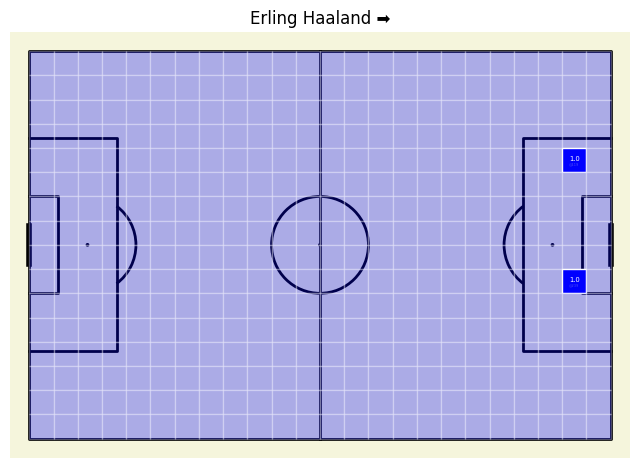

In [60]:
player_data = stats_df.iloc[9].Player
test_action_list = player_stats[player_data]["Shot"]["locations"]
Draw_Pitch_Actions(test_action_list, False, "data/location_df.csv", player_data).plot().save_fig("plots_imgs/player.png")

In [32]:
# x_data["players_df"][["Name","Club","Playing_Position","Pos_Rank_Average"]]
# x_data["match_data"], y_data["match_data"]

In [33]:
lineup_x[["Name","Club","Playing_Position","Pos_Rank_Average"]]

,Name,Club,Playing_Position,Pos_Rank_Average
91,Alisson,Liverpool,GK,0
98,Trent Alexander-Arnold,Liverpool,DR,3
90,Virgil van Dijk,Liverpool,DC,3
108,Kostas Tsimikas,Liverpool,DL,4
93,Fabinho,Liverpool,DC,4
96,Jordan Henderson,Liverpool,MC,6
92,Thiago,Liverpool,MC,7
106,Alex Oxlade-Chamberlain,Liverpool,AMC,8
94,Roberto Firmino,Liverpool,AMR,11
89,Mohamed Salah,Liverpool,AML,12


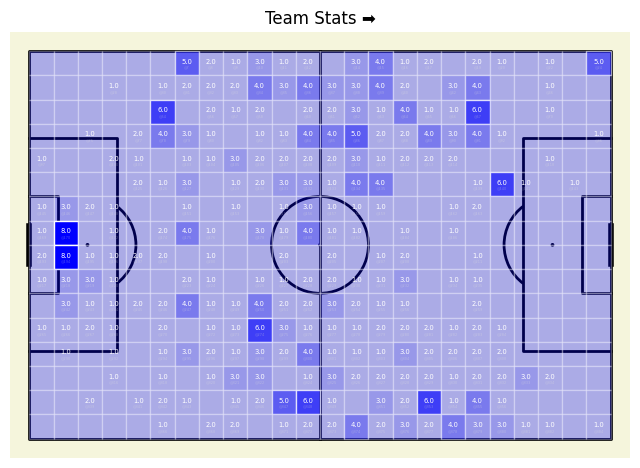

In [34]:
Draw_Pitch_Actions(x_data["pass_map"], False, "data/location_df.csv", "Team Stats").plot().save_fig("plots_imgs/volumer.png")

In [63]:
x_data["lineup"][["Name","pass_weight_prob","shot_weight_prob","dribble_weight_prob"]]

,Name,pass_weight_prob,shot_weight_prob,dribble_weight_prob
149,Ederson,0.065773,0.000000,0.000000
158,Kyle Walker,0.105622,0.056689,0.080154
147,Rúben Dias,0.109490,0.042630,0.029576
150,Aymeric Laporte,0.119077,0.058503,0.044578
153,João Cancelo,0.104954,0.089342,0.120874
152,İlkay Gündogan,0.096035,0.099320,0.082726
145,Kevin De Bruyne,0.100146,0.123810,0.095585
148,Bernardo Silva,0.083778,0.117460,0.131590
156,Jack Grealish,0.075890,0.119728,0.145735
154,Phil Foden,0.076330,0.130159,0.152593


<br><br><br><br><br><br><br><br>
<h2 style="color:white;background:gray;"> _***Triple_Prob_Dict</h2>

In [36]:
pass_df = pd.read_csv("../match_logs/Big5@22-23@passing.csv")[["Att","Club"]].groupby(by="Club").mean().reset_index().sort_values("Att", ascending=False)
shot_df = pd.read_csv("../match_logs/Big5@22-23@shooting.csv")[["Sh","Club"]].groupby(by="Club").mean().reset_index().sort_values("Sh", ascending=False)
dribble_df = pd.read_csv("../match_logs/Big5@22-23@possession.csv")[["Att","Club"]].groupby(by="Club").mean().reset_index().sort_values("Att", ascending=False)
merged_df = pd.merge(
    pass_df.merge(shot_df, on="Club", suffixes=("", "_shot")),
    dribble_df, on="Club", suffixes=("_pass", "_dribble")
)
merged_df.rename(columns={"Sh":"Att_shot"}, inplace=True)
action_columns = merged_df.select_dtypes(exclude="object").columns
merged_df["Total_touches"] = merged_df.apply(lambda row: row[action_columns].sum(), axis=1)
merged_df["%pass"] = merged_df["Att_pass"] / merged_df["Total_touches"]
merged_df["%shot"] = merged_df["Att_shot"] / merged_df["Total_touches"]
merged_df["%dribble"] = merged_df["Att_dribble"] /  merged_df["Total_touches"]
merged_df["Triple_Prob_Dict"] = merged_df.apply(lambda row: {
    "Pass": (row["Att_pass"]/row["Total_touches"]),
    "Shot": (row["Att_shot"]/row["Total_touches"]),
    "Dribble": (row["Att_dribble"]/row["Total_touches"]),
}, axis=1)
# merged_df.to_csv("../match_logs/Big5@22-23@triple_stats.csv", index=False)